In [1]:
import os
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import average_precision_score

np.random.seed(2019)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import lightgbm as lgb

In [2]:
import plotly
import plotly.graph_objs as go
import cufflinks as cf
cf.set_config_file(offline=True)

In [3]:
base_path = os.path.abspath('../..')
data_path = os.path.join(base_path, 'data')
database_path = os.path.join(data_path, 'database')
strategy_path = os.path.join(base_path, 'strategy')
sys.path.append(strategy_path)

In [4]:
from strategy import CommodityStrategy, EquityStrategy, IRStrategy, EmergingStrategy
from tester import Tester

In [5]:
from models.CRNN import CRNN_model

# 1. Data

In [6]:
strategy = EmergingStrategy(strategy_name="EMPM", asset_type="EQUITY")
strategy.load_index_and_return(from_db=True, save_file=True)

strategy.index.columns.name = 'ticker'
strategy.ret.columns.name = 'ticker'

strategy.index.index.name = 'tdate'
strategy.ret.index.name = 'tdate'

strategy.index.drop_duplicates(inplace=True)
strategy.ret.drop_duplicates(inplace=True)

df_index = strategy.index.loc[:'2019-07']
df_index_return = strategy.ret.loc[:'2019-07']

2020-02-04 15:35:19,031 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2020-02-04 15:35:19,034 - EMPM - INFO - [STEP 1] LOAD DATA
2020-02-04 15:35:19,035 - EMPM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-02-04 15:35:19,052 - EMPM - INFO - [STEP 1 - 3] CHANGE BLOOM AND PAST DATA INTO STANDARD FORMAT
2020-02-04 15:35:22,297 - EMPM - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 15:35:24,926 - EMPM - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 15:35:42,420 - EMPM - INFO - [STEP 1 - 4] MERGE BLOOM AND PAST DATA
2020-02-04 15:35:42,428 - EMPM - INFO - [STEP 1 - 5] SAVE RETURN DATA INTO CSV FORMAT


In [7]:
df_index = strategy.index.loc[:'2019-07']
df_index_return = strategy.ret.loc[:'2019-07']

# 2. Explore

In [8]:
plt.figure(figsize=(15,5))
for column in df_index.columns:
    df_index[column].plot()
plt.legend()

In [9]:
plt.figure(figsize=(15,5))
for column in df_index_return.columns:
    df_index_return[column].plot()
plt.legend()

# 3. Model

In [10]:
indiv_momentum_lst = [5, 10, 21, 42, 63, 126, 252]

# 1. FEATURE

### average return

In [11]:
avg_ret  = {}
for i, period in enumerate(indiv_momentum_lst):
    avg_ret['avg_ret_' + str(period)] = df_index_return.rolling(period).mean()

### average vol

In [12]:
avg_vol  = {}
for i, period in enumerate(indiv_momentum_lst):
    avg_vol['avg_vol_' + str(period)] = df_index_return.rolling(period).std()

### cum return

In [13]:
cum_ret  = {}
for i, period in enumerate(indiv_momentum_lst):
    cum_ret['cum_ret_' + str(period)] = df_index.pct_change(period)

In [14]:
df_mom_avg_ret = pd.concat(avg_ret, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_mom_avg_vol = pd.concat(avg_vol, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_mom_cum_ret = pd.concat(cum_ret, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]

# 2. 성과

# CASE 0. 기존(머신러닝 사용 X)

In [15]:
from EMPM import EMPM

In [16]:
empm = EMPM(strategy_name="EMPM", asset_type="EMERGING")
empm.load_index_and_return(from_db=True, save_file=True)
empm.set_rebalance_period(ts_freq='month', cs_freq='week', rebalance_weekday=1)  # rebalance_day: monday = 0, sunday = 6
empm.calculate_signal(CS=0.35, minobs=260, minobs1=52, longlen1=52, longlen2=13, shortlen=2)
empm.set_portfolio_parameter(cs_strategy_type='notional')
empm.make_portfolio()

2020-02-04 15:35:43,280 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2020-02-04 15:35:43,280 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2020-02-04 15:35:43,282 - EMPM - INFO - [STEP 1] LOAD DATA
2020-02-04 15:35:43,282 - EMPM - INFO - [STEP 1] LOAD DATA
2020-02-04 15:35:43,284 - EMPM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-02-04 15:35:43,284 - EMPM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-02-04 15:35:43,286 - EMPM - INFO - [STEP 1 - 3] CHANGE BLOOM AND PAST DATA INTO STANDARD FORMAT
2020-02-04 15:35:43,286 - EMPM - INFO - [STEP 1 - 3] CHANGE BLOOM AND PAST DATA INTO STANDARD FORMAT
2020-02-04 15:35:46,154 - EMPM - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 15:35:46,154 - EMPM - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 15:35:48,683 - EMPM - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 15:35:48,683 - EMPM - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 15:36:0

In [17]:
start_date = '2011-01-01'
end_date = '2018-05-09'

# get r results
empm_comp_df = pd.read_csv('../check/past/empm.csv', header=0, index_col=0, parse_dates=True)
empm_lag_comp_df = pd.read_csv('../check/past/empm_lag.csv', header=0, index_col=0, parse_dates=True)

### 1. PYTHON & R

In [18]:
tester = Tester(empm)
tester.set_period(start=start_date, end=end_date)
tester.run(save_file=False, use_bt=False)

2020-02-04 15:36:51,357 - EMPM - INFO - [STEP 6] START BACKTEST
2020-02-04 15:36:51,357 - EMPM - INFO - [STEP 6] START BACKTEST
2020-02-04 15:36:51,358 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2020-02-04 15:36:51,358 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2020-02-04 15:36:51,957 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2020-02-04 15:36:51,957 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL


In [19]:
to_plot = (1.+ empm_lag_comp_df).loc[start_date:].cumprod()
to_plot['TS_python'] = tester.strategy.TS_result
to_plot['CS_python'] = tester.strategy.CS_result
to_plot.iplot()

# CASE 1. BINARY

- Binary로 나누어서 학습하고 상위 30% 하위 30% 롱숏

In [20]:
one_month = 21
df_index_rank = df_index.pct_change(one_month).shift(-1 * one_month).rank(axis=1) 
df_index_y_binary = df_index_rank > df_index_rank.shape[1] / 2
df_index_y_binary = df_index_y_binary.astype(np.float32)

In [21]:
df_y = df_index_y_binary.unstack().reset_index()
df_y = df_y.set_index('tdate').loc['1994':]
df_y.columns = ['ticker', 'y']

In [22]:
df_mom_cum_ret.reset_index(inplace=True)
df_mom_avg_ret.reset_index(inplace=True)
df_mom_avg_vol.reset_index(inplace=True)

df_join = pd.merge(df_y, df_mom_avg_ret, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_mom_avg_vol, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_mom_cum_ret, on=['tdate', 'ticker'])

df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime('2005-12-31')]
df_val = df_join.loc[(df_join['tdate'] >= pd.to_datetime('2006-01-01')) & (df_join['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[3:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [23]:
def train_tree(train_x, train_y1, val_x, val_y1, max_depth=7, fraction=0.8, num_leaves=50, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, random_state=1, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': max_depth,
          'num_leaves': num_leaves,
          "learning_rate": learning_rate,
          "feature_fraction": fraction,
          "subsample": fraction,
          "verbosity": verbose,
          "metric": 'binary_logloss',
          'random_state': random_state
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [24]:
model, train_pred, val_pred = train_tree(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                         max_depth=5, num_leaves=20, fraction=0.6,
                                         num_boost_round=10000, 
                                         learning_rate=0.001, 
                                         verbose=10,
                                         early_stopping_rounds=100,
                                         random_state=i+1)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.692762	valid_1's binary_logloss: 0.693146
[20]	training's binary_logloss: 0.692402	valid_1's binary_logloss: 0.693139
[30]	training's binary_logloss: 0.692049	valid_1's binary_logloss: 0.693145
[40]	training's binary_logloss: 0.691706	valid_1's binary_logloss: 0.693126
[50]	training's binary_logloss: 0.691345	valid_1's binary_logloss: 0.693149
[60]	training's binary_logloss: 0.690984	valid_1's binary_logloss: 0.693142
[70]	training's binary_logloss: 0.690619	valid_1's binary_logloss: 0.693173
[80]	training's binary_logloss: 0.690283	valid_1's binary_logloss: 0.693161
[90]	training's binary_logloss: 0.68994	valid_1's binary_logloss: 0.693182
[100]	training's binary_logloss: 0.689592	valid_1's binary_logloss: 0.693188
[110]	training's binary_logloss: 0.689258	valid_1's binary_logloss: 0.693194
[120]	training's binary_logloss: 0.688914	valid_1's binary_logloss: 0.693197
[130]	training's binary_

In [25]:
%matplotlib inline

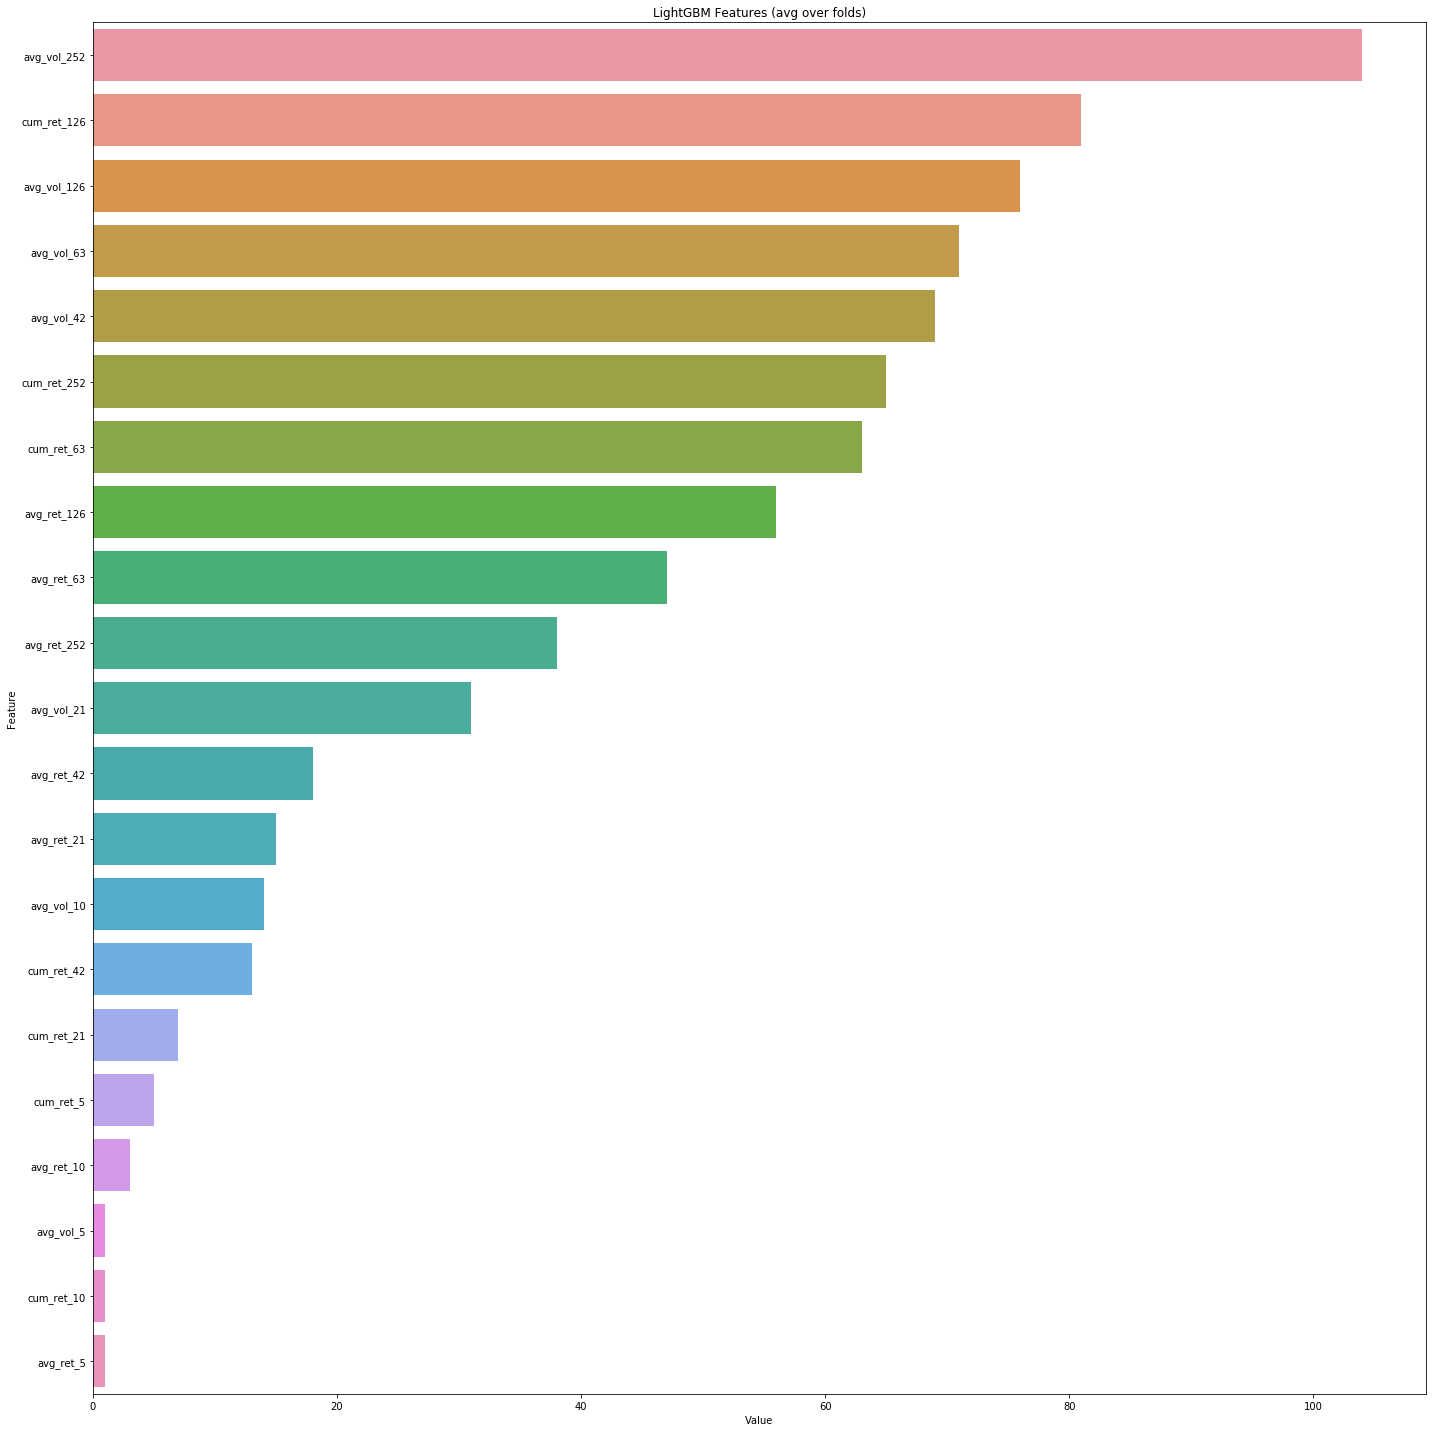

In [26]:
supply_demand_feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(), df_train.columns[3:])), columns=['Value','Feature'])
plt.figure(figsize=(20, 20))
sns.barplot(x="Value", y="Feature", data=supply_demand_feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [27]:
test_pred = model.predict(df_test_x.values)

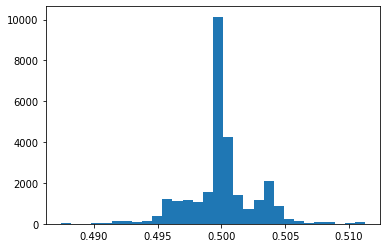

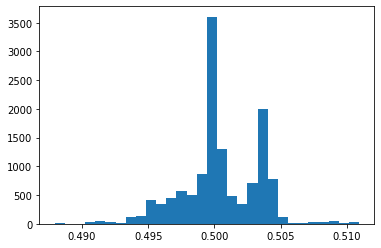

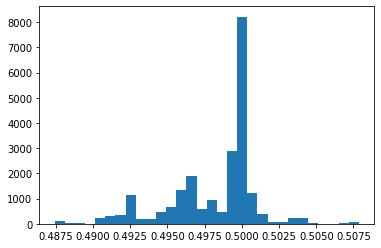

In [28]:
plt.hist(train_pred, bins=30)
plt.show()

plt.hist(val_pred, bins=30)
plt.show()

plt.hist(test_pred, bins=30)
plt.show()

### 결과

In [29]:
df_train['y_pred'] = train_pred
df_val['y_pred'] = val_pred
df_test['y_pred'] = test_pred
df_train_pred = pd.pivot_table(df_train, columns='ticker', index='tdate', values='y_pred')
df_val_pred = pd.pivot_table(df_val, columns='ticker', index='tdate', values='y_pred')
df_test_pred = pd.pivot_table(df_test, columns='ticker', index='tdate', values='y_pred')
df_pred = pd.concat([df_train_pred, df_val_pred, df_test_pred], axis=0)

In [30]:
df_index_sub = df_index.loc['1994':]
long = df_pred.shape[1] / 10 * 7
short = df_pred.shape[1] / 10 * 3

df_pred_rank = df_pred.rank(axis=1)
df_pred_long = (df_pred_rank > long).astype(np.float32)
df_pred_short = (df_pred_rank < short).astype(np.float32)
df_pred_long_short = df_pred_long - df_pred_short
strategy.set_rebalance_period(ts_freq='month', cs_freq='week', rebalance_weekday=1)  # rebalance_day: monday = 0, sunday = 6
strategy.TSRV = df_pred_long_short
strategy.CSRV = df_pred_long_short

2020-02-04 15:36:54,607 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2020-02-04 15:36:54,607 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD


In [31]:
strategy.set_portfolio_parameter(cs_strategy_type='notional')
strategy.make_portfolio()

2020-02-04 15:36:54,613 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2020-02-04 15:36:54,613 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2020-02-04 15:36:54,614 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2020-02-04 15:36:54,614 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2020-02-04 15:36:54,615 - EMPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2020-02-04 15:36:54,615 - EMPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2020-02-04 15:37:27,701 - EMPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2020-02-04 15:37:27,701 - EMPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2020-02-04 15:37:27,702 - EMPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2020-02-04 15:37:27,702 - EMPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2020-02-04 15:37:30,048 - EMPM - INFO - [STEP 5 - 2 - 2] TARGET VOL CONTROL to TS POSITION
2020-02-04 15:37:30,048 - EMPM - INFO - [STEP 5 - 2 - 2] TARGET VOL CONTROL to TS POSITION
2020-02-04 15:37:30,055 - EMPM - INFO - [STEP 5 - 2 - 3] STRATEGY LE

### TEST

In [32]:
tester1 = Tester(strategy)
tester1.set_period(start=start_date, end=end_date)
tester1.run(use_bt=False)

2020-02-04 15:37:40,502 - EMPM - INFO - [STEP 6] START BACKTEST
2020-02-04 15:37:40,502 - EMPM - INFO - [STEP 6] START BACKTEST
2020-02-04 15:37:40,503 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2020-02-04 15:37:40,503 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2020-02-04 15:37:40,882 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2020-02-04 15:37:40,882 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL


In [33]:
to_plot['CS_ML'] = tester1.strategy.CS_result

In [34]:
to_plot.iplot()

# CASE 2. 70% 강조

- 상위 30%에 속하는 데이터와 하위 30%에 속하는 데이터로 학습한다.

In [35]:
one_month = 21
df_index_rank = df_index.pct_change(one_month).shift(-1 * one_month).rank(axis=1) 

In [36]:
df_index_y_binary1 = df_index_rank > df_index_rank.shape[1] / 3 * 2
df_index_y_binary1 = df_index_y_binary1.astype(np.float32)
df_y = df_index_y_binary1.unstack().reset_index()
df_y = df_y.set_index('tdate').loc['1994':]
df_y.columns = ['ticker', 'y']

In [37]:
df_join2 = pd.merge(df_y, df_mom_avg_ret, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_mom_avg_vol, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_mom_cum_ret, on=['tdate', 'ticker'])

df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime('2005-12-31')]
df_val = df_join2.loc[(df_join2['tdate'] >= pd.to_datetime('2006-01-01')) & (df_join2['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join2.loc[df_join2['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[3:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [38]:
model, train_pred, val_pred = train_tree(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                         max_depth=5, num_leaves=20, fraction=0.6,
                                         num_boost_round=10000, 
                                         learning_rate=0.001, 
                                         verbose=10,
                                         early_stopping_rounds=100,
                                         random_state=i+1)

Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.672615	valid_1's binary_logloss: 0.672983
[20]	training's binary_logloss: 0.67223	valid_1's binary_logloss: 0.672955
[30]	training's binary_logloss: 0.671866	valid_1's binary_logloss: 0.672932
[40]	training's binary_logloss: 0.671529	valid_1's binary_logloss: 0.672899
[50]	training's binary_logloss: 0.671152	valid_1's binary_logloss: 0.672891
[60]	training's binary_logloss: 0.670769	valid_1's binary_logloss: 0.672877
[70]	training's binary_logloss: 0.670405	valid_1's binary_logloss: 0.672877
[80]	training's binary_logloss: 0.670052	valid_1's binary_logloss: 0.672863
[90]	training's binary_logloss: 0.669697	valid_1's binary_logloss: 0.672862
[100]	training's binary_logloss: 0.669328	valid_1's binary_logloss: 0.672864
[110]	training's binary_logloss: 0.668982	valid_1's binary_logloss: 0.672836
[120]	training's binary_logloss: 0.668626	valid_1's binary_logloss: 0.672828
[130]	training's binary_

In [39]:
test_pred = model.predict(df_test_x.values)

In [40]:
df_train['y_pred'] = train_pred
df_val['y_pred'] = val_pred
df_test['y_pred'] = test_pred
df_train_pred = pd.pivot_table(df_train, columns='ticker', index='tdate', values='y_pred')
df_val_pred = pd.pivot_table(df_val, columns='ticker', index='tdate', values='y_pred')
df_test_pred = pd.pivot_table(df_test, columns='ticker', index='tdate', values='y_pred')

df_pred2 = pd.concat([df_train_pred, df_val_pred, df_test_pred], axis=0)

In [41]:
long = df_pred2.shape[1] / 10 * 7
short = df_pred2.shape[1] / 10 * 3
df_pred_rank2 = df_pred2.rank(axis=1)
df_pred_long2 = (df_pred_rank2 > long).astype(np.float32)
df_pred_short2 = (df_pred_rank2 < short).astype(np.float32)
df_pred_long_short2 = df_pred_long2 - df_pred_short2

In [42]:
strategy2 = EMPM(strategy_name="EMPM", asset_type="EQUITY")
strategy2.load_index_and_return(from_db=True, save_file=True)
strategy2.set_rebalance_period(ts_freq='month', cs_freq='week', rebalance_weekday=1)  # rebalance_day: monday = 0, sunday = 6
strategy2.TSRV = df_pred_long_short2
strategy2.CSRV = df_pred_long_short2
strategy2.set_portfolio_parameter(cs_strategy_type='notional')
strategy2.make_portfolio()

2020-02-04 15:37:42,888 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2020-02-04 15:37:42,888 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2020-02-04 15:37:42,888 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2020-02-04 15:37:42,890 - EMPM - INFO - [STEP 1] LOAD DATA
2020-02-04 15:37:42,890 - EMPM - INFO - [STEP 1] LOAD DATA
2020-02-04 15:37:42,890 - EMPM - INFO - [STEP 1] LOAD DATA
2020-02-04 15:37:42,892 - EMPM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-02-04 15:37:42,892 - EMPM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-02-04 15:37:42,892 - EMPM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-02-04 15:37:42,893 - EMPM - INFO - [STEP 1 - 3] CHANGE BLOOM AND PAST DATA INTO STANDARD FORMAT
2020-02-04 15:37:42,893 - EMPM - INFO - [STEP 1 - 3] CHANGE BLOOM AND PAST DATA INTO STANDARD FORMAT
2020-02-04 15:37:42,893 - EMPM - INFO - [STEP 1 - 3] CHANGE BLOOM AND PAST DATA INTO STANDARD FORMAT
2020-02-04 15:37:46,689 - EMPM - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STA

### TEST

In [43]:
tester2 = Tester(strategy2)
tester2.set_period(start=start_date, end=end_date)
tester2.run(use_bt=False)

2020-02-04 15:38:55,289 - EMPM - INFO - [STEP 6] START BACKTEST
2020-02-04 15:38:55,289 - EMPM - INFO - [STEP 6] START BACKTEST
2020-02-04 15:38:55,289 - EMPM - INFO - [STEP 6] START BACKTEST
2020-02-04 15:38:55,292 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2020-02-04 15:38:55,292 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2020-02-04 15:38:55,292 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2020-02-04 15:38:55,706 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2020-02-04 15:38:55,706 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2020-02-04 15:38:55,706 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL


In [44]:
to_plot['CS_ML_UPPER'] = tester2.strategy.CS_result

In [45]:
to_plot.iplot()

In [46]:
result = pd.concat([empm.CS_summary,
                    empm.TS_summary,
                    strategy.CS_summary,
                    strategy2.CS_summary], axis=1)

In [47]:
result

,0,1,2,3
TURNOVER,8.396773,0.599261,1.525595,1.459415
MDD,-0.067580,-0.032409,-0.049091,-0.032274
CAGR,0.003671,0.005752,-0.001563,0.006052
CAGR_TR,-0.006500,0.005063,-0.003399,0.004284
VOL,0.001371,0.001043,0.001327,0.001322
SHARPE,0.175780,0.347781,-0.062306,0.292128
SHARPE_TR,-0.282585,0.307228,-0.147998,0.210027


In [48]:
result.columns = ['CS_python', 'TS_python', 'CS_ML', 'CS_ML_UPPER']

# CASE 3. Case1을 Rolling으로 실행

In [49]:
val_rolling_one_year = ['2007-12-31',
                    '2008-12-31',
                    '2009-12-31',
                    '2010-12-31',
                    '2011-12-31',
                    '2012-12-31',
                    '2013-12-31',
                    '2014-12-31',
                    '2015-12-31']

In [50]:
test_rolling_one_year = ['2010-12-31',
                    '2011-12-31',
                    '2012-12-31',
                    '2013-12-31',
                    '2014-12-31',
                    '2015-12-31',
                    '2016-12-31',
                    '2017-12-31',
                    '2018-12-31']

In [51]:
models = []
train_preds = []
val_preds = []
test_preds = []

In [52]:
for i, one_year in enumerate(val_rolling_one_year):
    df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime(val_rolling_one_year[i])]
    
    if i == len(val_rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(test_rolling_one_year[i])]
        df_val = df_join.loc[(df_join['tdate'] > pd.to_datetime(val_rolling_one_year[i])) & 
                     (df_join['tdate'] <= pd.to_datetime(test_rolling_one_year[i]))]
    else:
        df_val = df_join.loc[(df_join['tdate'] > pd.to_datetime(val_rolling_one_year[i])) & 
                             (df_join['tdate'] <= pd.to_datetime(test_rolling_one_year[i]))]
        
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(test_rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(test_rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]
    
    df_val_y = df_val['y']
    df_val_x = df_val[df_val.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, val_pred = train_tree(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                         max_depth=5, num_leaves=20, fraction=0.6,
                                         num_boost_round=10000, 
                                         learning_rate=0.001, 
                                         verbose=10,
                                         early_stopping_rounds=100,
                                         random_state=0)
    test_pred = model.predict(df_test_x.values)
    df_train['y_pred'] = train_pred
    df_val['y_pred'] = val_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    val_preds.append(df_val)
    test_preds.append(df_test)

Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.692895	valid_1's binary_logloss: 0.693119
[20]	training's binary_logloss: 0.692611	valid_1's binary_logloss: 0.693075
[30]	training's binary_logloss: 0.69234	valid_1's binary_logloss: 0.693021
[40]	training's binary_logloss: 0.692061	valid_1's binary_logloss: 0.692981
[50]	training's binary_logloss: 0.691787	valid_1's binary_logloss: 0.692961
[60]	training's binary_logloss: 0.691521	valid_1's binary_logloss: 0.692946
[70]	training's binary_logloss: 0.691258	valid_1's binary_logloss: 0.692905
[80]	training's binary_logloss: 0.690989	valid_1's binary_logloss: 0.692871
[90]	training's binary_logloss: 0.690723	valid_1's binary_logloss: 0.692851
[100]	training's binary_logloss: 0.690463	valid_1's binary_logloss: 0.692838
[110]	training's binary_logloss: 0.690207	valid_1's binary_logloss: 0.692822
[120]	training's binary_logloss: 0.689956	valid_1's binary_logloss: 0.692793
[130]	training's binary_

Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.692963	valid_1's binary_logloss: 0.693143
[20]	training's binary_logloss: 0.692772	valid_1's binary_logloss: 0.693145
[30]	training's binary_logloss: 0.692566	valid_1's binary_logloss: 0.693148
[40]	training's binary_logloss: 0.692362	valid_1's binary_logloss: 0.693149
[50]	training's binary_logloss: 0.692171	valid_1's binary_logloss: 0.693127
[60]	training's binary_logloss: 0.691965	valid_1's binary_logloss: 0.693124
[70]	training's binary_logloss: 0.691756	valid_1's binary_logloss: 0.69313
[80]	training's binary_logloss: 0.691568	valid_1's binary_logloss: 0.693121
[90]	training's binary_logloss: 0.691368	valid_1's binary_logloss: 0.693122
[100]	training's binary_logloss: 0.691164	valid_1's binary_logloss: 0.693119
[110]	training's binary_logloss: 0.690979	valid_1's binary_logloss: 0.693127
[120]	training's binary_logloss: 0.69079	valid_1's binary_logloss: 0.693136
[130]	training's binary_l

In [53]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

(array([2.0000e+01, 1.1000e+01, 8.0000e+00, 3.3000e+01, 5.9000e+01,
        1.1400e+02, 9.9000e+01, 9.4000e+01, 2.8000e+02, 2.7600e+02,
        1.9300e+02, 7.0000e+00, 3.5000e+01, 8.3000e+01, 8.0300e+02,
        3.4760e+03, 1.4211e+04, 1.8350e+03, 3.1600e+02, 1.1600e+02,
        1.3300e+02, 7.2000e+01, 1.6000e+01, 1.0000e+01, 8.0000e+00,
        1.6000e+01, 2.0000e+01, 4.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([0.46215615, 0.46440712, 0.46665809, 0.46890906, 0.47116002,
        0.47341099, 0.47566196, 0.47791293, 0.48016389, 0.48241486,
        0.48466583, 0.4869168 , 0.48916777, 0.49141873, 0.4936697 ,
        0.49592067, 0.49817164, 0.5004226 , 0.50267357, 0.50492454,
        0.50717551, 0.50942647, 0.51167744, 0.51392841, 0.51617938,
        0.51843035, 0.52068131, 0.52293228, 0.52518325, 0.52743422,
        0.52968518]),
 <a list of 30 Patch objects>)

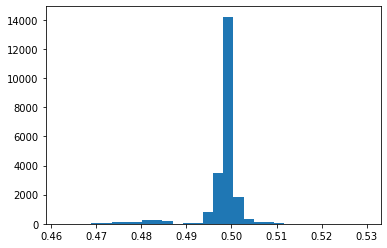

In [54]:
plt.hist(df_test_concat['y_pred'], bins=30)

In [55]:
long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

df_pred_rank3 = df_test_pred.rank(axis=1)
df_pred_long3 = (df_pred_rank3 > long).astype(np.float32)
df_pred_short3 = (df_pred_rank3 < short).astype(np.float32)
df_pred_long_short3 = df_pred_long3 - df_pred_short3

In [56]:
strategy3 = EMPM(strategy_name="EMPM", asset_type="EQUITY")
strategy3.load_index_and_return(from_db=True, save_file=True)
strategy3.index.drop_duplicates(inplace=True)
strategy3.ret.drop_duplicates(inplace=True)

2020-02-04 15:39:01,234 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2020-02-04 15:39:01,234 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2020-02-04 15:39:01,234 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2020-02-04 15:39:01,234 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2020-02-04 15:39:01,237 - EMPM - INFO - [STEP 1] LOAD DATA
2020-02-04 15:39:01,237 - EMPM - INFO - [STEP 1] LOAD DATA
2020-02-04 15:39:01,237 - EMPM - INFO - [STEP 1] LOAD DATA
2020-02-04 15:39:01,237 - EMPM - INFO - [STEP 1] LOAD DATA
2020-02-04 15:39:01,239 - EMPM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-02-04 15:39:01,239 - EMPM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-02-04 15:39:01,239 - EMPM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-02-04 15:39:01,239 - EMPM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-02-04 15:39:01,241 - EMPM - INFO - [STEP 1 - 3] CHANGE BLOOM AND PAST DATA INTO STANDARD FORMAT
2020-02-04 15:39:01,241 - EMPM - INFO - [STEP 1 - 3] CHANGE BLOOM AND PAST 

In [57]:
strategy3.TSRV = df_pred_long_short3
strategy3.CSRV = df_pred_long_short3

strategy3.set_rebalance_period(ts_freq='month', cs_freq='week', rebalance_weekday=1)  # rebalance_day: monday = 0, sunday = 6
strategy3.set_portfolio_parameter(cs_strategy_type='notional')
strategy3.make_portfolio()

2020-02-04 15:39:25,523 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2020-02-04 15:39:25,523 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2020-02-04 15:39:25,523 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2020-02-04 15:39:25,523 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2020-02-04 15:39:25,525 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2020-02-04 15:39:25,525 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2020-02-04 15:39:25,525 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2020-02-04 15:39:25,525 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2020-02-04 15:39:25,527 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2020-02-04 15:39:25,527 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2020-02-04 15:39:25,527 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2020-02-04 15:39:25,527 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2020-02-04 15:39:25,528 - EMPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2020-02-04 15:39:25,528 - EMPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2020-02-04 15:39:25,528 

In [58]:
tester3 = Tester(strategy3)
tester3.set_period(start=start_date, end=end_date)
tester3.run(use_bt=False)

2020-02-04 15:40:01,618 - EMPM - INFO - [STEP 6] START BACKTEST
2020-02-04 15:40:01,618 - EMPM - INFO - [STEP 6] START BACKTEST
2020-02-04 15:40:01,618 - EMPM - INFO - [STEP 6] START BACKTEST
2020-02-04 15:40:01,618 - EMPM - INFO - [STEP 6] START BACKTEST
2020-02-04 15:40:01,620 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2020-02-04 15:40:01,620 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2020-02-04 15:40:01,620 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2020-02-04 15:40:01,620 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2020-02-04 15:40:01,894 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2020-02-04 15:40:01,894 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2020-02-04 15:40:01,894 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2020-02-04 15:40:01,894 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL


In [59]:
to_plot['CS_ML_ROLLING'] = tester3.strategy.CS_result

In [60]:
to_plot.iplot()

In [61]:
result = pd.concat([empm.CS_summary,
                    empm.TS_summary,
                    strategy.CS_summary,
                    strategy2.CS_summary,
                    strategy3.CS_summary], axis=1)

In [62]:
result.columns = ['CS_python', 'TS_python', 'CS_ML', 'CS_ML_UPPER', 'CS_ML_ROLLING']

In [63]:
result

,CS_python,TS_python,CS_ML,CS_ML_UPPER,CS_ML_ROLLING
TURNOVER,8.396773,0.599261,1.525595,1.459415,1.387962
MDD,-0.067580,-0.032409,-0.049091,-0.032274,-0.092530
CAGR,0.003671,0.005752,-0.001563,0.006052,-0.012624
CAGR_TR,-0.006500,0.005063,-0.003399,0.004284,-0.014125
VOL,0.001371,0.001043,0.001327,0.001322,0.001291
SHARPE,0.175780,0.347781,-0.062306,0.292128,-0.597851
SHARPE_TR,-0.282585,0.307228,-0.147998,0.210027,-0.670678


# CASE 4. CASE 2를 ROLLING으로 실행

In [64]:
models = []
train_preds = []
val_preds = []
test_preds = []

In [65]:
for i, one_year in enumerate(val_rolling_one_year):
    df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime(val_rolling_one_year[i])]
    
    if i == len(val_rolling_one_year) - 1:
        df_test = df_join2.loc[df_join2['tdate'] > pd.to_datetime(test_rolling_one_year[i])]
        df_val = df_join2.loc[(df_join2['tdate'] > pd.to_datetime(val_rolling_one_year[i])) & 
                     (df_join2['tdate'] <= pd.to_datetime(test_rolling_one_year[i]))]
    else:
        df_val = df_join2.loc[(df_join2['tdate'] > pd.to_datetime(val_rolling_one_year[i])) & 
                             (df_join2['tdate'] <= pd.to_datetime(test_rolling_one_year[i]))]
        
        df_test = df_join2.loc[(df_join2['tdate'] <= pd.to_datetime(test_rolling_one_year[i+1])) & 
                              (df_join2['tdate'] > pd.to_datetime(test_rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]
    
    df_val_y = df_val['y']
    df_val_x = df_val[df_val.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, val_pred = train_tree(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                         max_depth=5, num_leaves=20, fraction=0.6,
                                         num_boost_round=10000, 
                                         learning_rate=0.001, 
                                         verbose=10,
                                         early_stopping_rounds=100,
                                         random_state=0)
    test_pred = model.predict(df_test_x.values)
    df_train['y_pred'] = train_pred
    df_val['y_pred'] = val_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    val_preds.append(df_val)
    test_preds.append(df_test)

Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.672711	valid_1's binary_logloss: 0.672963
[20]	training's binary_logloss: 0.672385	valid_1's binary_logloss: 0.672901
[30]	training's binary_logloss: 0.672064	valid_1's binary_logloss: 0.672817
[40]	training's binary_logloss: 0.671719	valid_1's binary_logloss: 0.672707
[50]	training's binary_logloss: 0.6714	valid_1's binary_logloss: 0.672623
[60]	training's binary_logloss: 0.671088	valid_1's binary_logloss: 0.672572
[70]	training's binary_logloss: 0.670783	valid_1's binary_logloss: 0.672514
[80]	training's binary_logloss: 0.670502	valid_1's binary_logloss: 0.672454
[90]	training's binary_logloss: 0.670214	valid_1's binary_logloss: 0.672439
[100]	training's binary_logloss: 0.669925	valid_1's binary_logloss: 0.672398
[110]	training's binary_logloss: 0.669643	valid_1's binary_logloss: 0.67237
[120]	training's binary_logloss: 0.669358	valid_1's binary_logloss: 0.67233
[130]	training's binary_log

[410]	training's binary_logloss: 0.662854	valid_1's binary_logloss: 0.672216
[420]	training's binary_logloss: 0.662639	valid_1's binary_logloss: 0.672193
[430]	training's binary_logloss: 0.66243	valid_1's binary_logloss: 0.672175
[440]	training's binary_logloss: 0.662218	valid_1's binary_logloss: 0.67215
[450]	training's binary_logloss: 0.662002	valid_1's binary_logloss: 0.67214
[460]	training's binary_logloss: 0.661793	valid_1's binary_logloss: 0.672165
[470]	training's binary_logloss: 0.661578	valid_1's binary_logloss: 0.67214
[480]	training's binary_logloss: 0.661369	valid_1's binary_logloss: 0.672145
[490]	training's binary_logloss: 0.661155	valid_1's binary_logloss: 0.672105
[500]	training's binary_logloss: 0.660957	valid_1's binary_logloss: 0.672077
[510]	training's binary_logloss: 0.660747	valid_1's binary_logloss: 0.672053
[520]	training's binary_logloss: 0.660529	valid_1's binary_logloss: 0.672071
[530]	training's binary_logloss: 0.660314	valid_1's binary_logloss: 0.672063
[54

[20]	training's binary_logloss: 0.672584	valid_1's binary_logloss: 0.672922
[30]	training's binary_logloss: 0.672346	valid_1's binary_logloss: 0.672884
[40]	training's binary_logloss: 0.672112	valid_1's binary_logloss: 0.672863
[50]	training's binary_logloss: 0.671893	valid_1's binary_logloss: 0.67282
[60]	training's binary_logloss: 0.671669	valid_1's binary_logloss: 0.672803
[70]	training's binary_logloss: 0.671441	valid_1's binary_logloss: 0.672795
[80]	training's binary_logloss: 0.671236	valid_1's binary_logloss: 0.672763
[90]	training's binary_logloss: 0.671009	valid_1's binary_logloss: 0.672744
[100]	training's binary_logloss: 0.670775	valid_1's binary_logloss: 0.672729
[110]	training's binary_logloss: 0.670571	valid_1's binary_logloss: 0.672707
[120]	training's binary_logloss: 0.67035	valid_1's binary_logloss: 0.672703
[130]	training's binary_logloss: 0.670118	valid_1's binary_logloss: 0.672712
[140]	training's binary_logloss: 0.66991	valid_1's binary_logloss: 0.672683
[150]	trai

In [66]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

In [67]:
df_pred_rank4 = df_test_pred.rank(axis=1)
df_pred_long4 = (df_pred_rank4 > long).astype(np.float32)
df_pred_short4 = (df_pred_rank4 < short).astype(np.float32)
df_pred_long_short4 = df_pred_long4 - df_pred_short4

In [68]:
strategy4 = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy4.load_index_and_return(from_db=False, save_file=False)
strategy4.index.drop_duplicates(inplace=True)
strategy4.ret.drop_duplicates(inplace=True)

2020-02-04 15:40:09,089 - EPM - INFO - [STEP 0] START LOGGING EPM
2020-02-04 15:40:09,091 - EPM - INFO - [STEP 1] LOAD DATA


AttributeError: 'NoneType' object has no attribute 'drop_duplicates'

In [ ]:
strategy4.TSRV = df_pred_long_short4
strategy4.CSRV = df_pred_long_short4

strategy4.set_rebalance_period(freq='month') 
strategy4.set_portfolio_parameter(cs_strategy_type='notional')
strategy4.make_portfolio()

In [ ]:
tester4 = Tester(strategy4)
tester4.set_period(start=start_date, end=end_date)
tester4.run()

In [ ]:
to_plot['CS_ML_UPPER_ROLLING'] = tester4.strategy.CS_result

In [ ]:
to_plot.iplot()

In [ ]:
result = pd.concat([epm.CS_summary,
                    epm.TS_summary,
                    strategy.CS_summary,
                    strategy2.CS_summary,
                    strategy3.CS_summary,
                    strategy4.CS_summary], axis=1)

In [ ]:
result

In [ ]:
result.columns = ['CS_python', 'TS_python', 'CS_ML', 'CS_ML_UPPER', 'CS_ML_ROLLING', 'CS_ML_UPPER_ROLING']

In [ ]:
result